/tmp/ipykernel_44015/3153986488.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


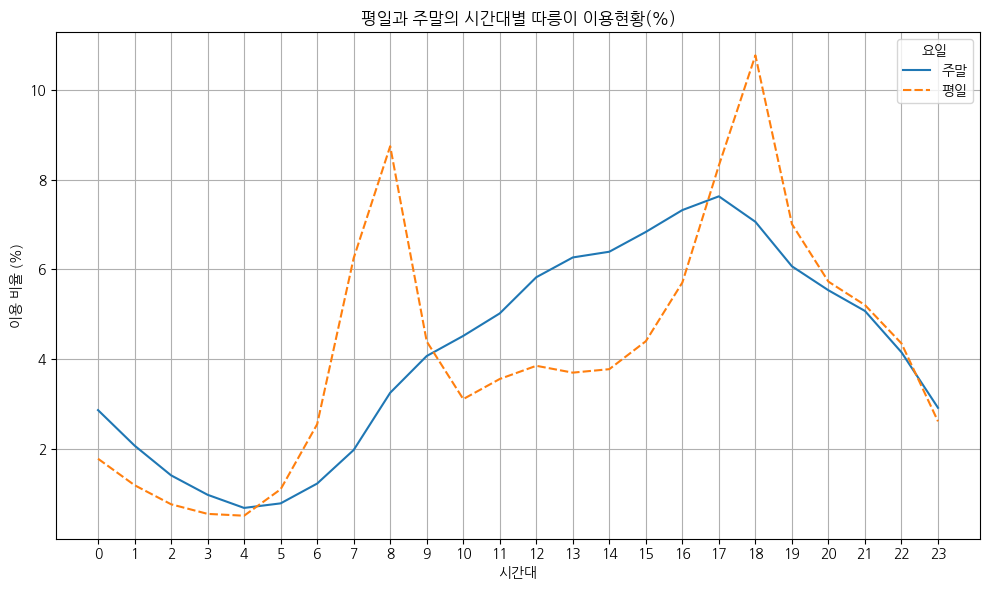

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import koreanize_matplotlib

# ✅ MySQL 연결
conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

# ✅ 데이터 불러오기 (수정된 테이블명)
query = "SELECT date AS rental_date, hour AS rental_hour, rental_count FROM rental_net_hourly_gu"
df = pd.read_sql(query, conn)
conn.close()

# ✅ 날짜 타입 변환 및 요일 계산
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['weekday'] = df['rental_date'].dt.weekday  # 0 = 월요일, 6 = 일요일
df['is_weekend'] = df['weekday'].apply(lambda x: '주말' if x >= 5 else '평일')

# ✅ 평일/주말별 시간대별 합계
pivot = df.groupby(['is_weekend', 'rental_hour'])['rental_count'].sum().reset_index()

# ✅ 비율 계산
pivot['total'] = pivot.groupby('is_weekend')['rental_count'].transform('sum')
pivot['percentage'] = pivot['rental_count'] / pivot['total'] * 100

# ✅ 피벗테이블 형태로 변환
plot_df = pivot.pivot(index='rental_hour', columns='is_weekend', values='percentage')

# ✅ 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df)
plt.title("평일과 주말의 시간대별 따릉이 이용현황(%)")
plt.xlabel("시간대")
plt.ylabel("이용 비율 (%)")
plt.xticks(range(0, 24))
plt.legend(title="요일")
plt.grid(True)
plt.tight_layout()
plt.show()


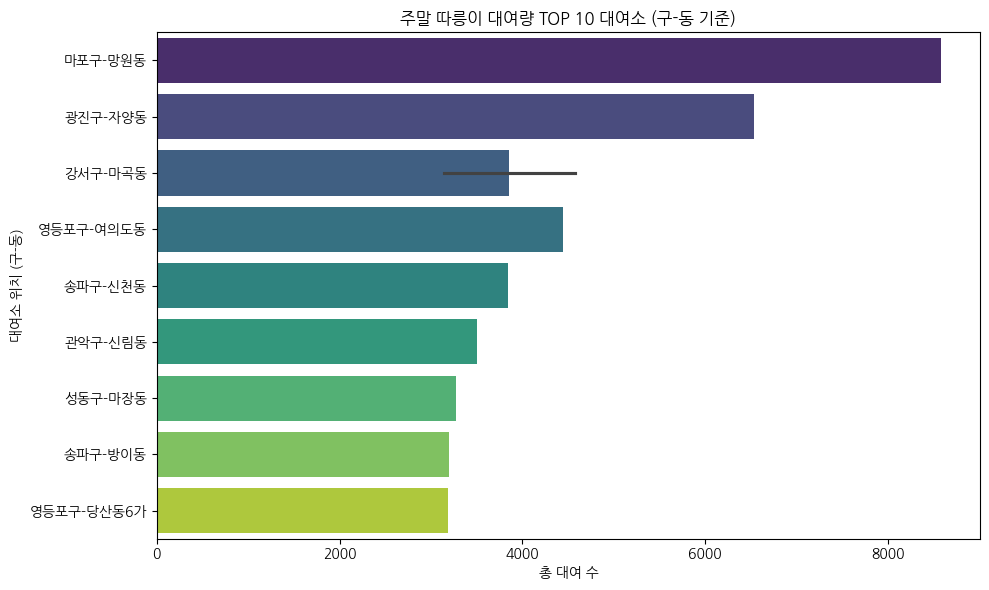

In [ ]:

from sqlalchemy import create_engine

# ✅ SQLAlchemy 엔진으로 연결 (pandas 경고 해결용)
engine = create_engine(
    "[]"
)

# ✅ 주말 상위 10개 대여소 불러오기
query = """
SELECT r.rental_station_id, r.total_rental_count, s.station_gu, s.station_dong
FROM rental_station_top10_holiday r
JOIN station s ON r.rental_station_id = s.station_id
"""
df = pd.read_sql(query, engine)

# ✅ 구-동 이름 만들기
df["label"] = df["station_gu"] + "-" + df["station_dong"]

# ✅ 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="total_rental_count", y="label", hue="label", palette="viridis", legend=False)

plt.title("주말 따릉이 대여량 TOP 10 대여소 (구-동 기준)")
plt.xlabel("총 대여 수")
plt.ylabel("대여소 위치 (구-동)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_44015/3927936667.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/tmp/ipykernel_44015/3927936667.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  station_df = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station", conn)
/tmp/ipykernel_44015/3927936667.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_station, x="rental_count", y="label", palette="viridis", errorbar=None)
/tmp/ipykernel_44015/3927936667.py:38: UserWarning: Glyph 9989 (\N{WHITE HEAVY

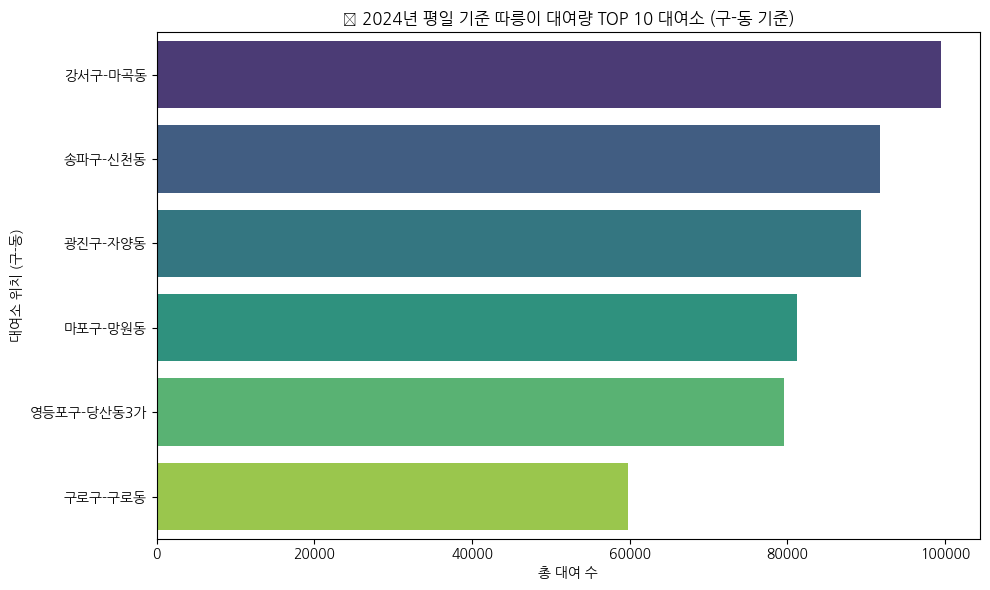

In [ ]:
conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

# ✅ rental_hourly_station 데이터 불러오기
query = """
SELECT rental_date, rental_station_id, rental_count
FROM rental_hourly_station
"""
df = pd.read_sql(query, conn)

# ✅ station 정보 불러오기 (구-동 매핑용)
station_df = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station", conn)
conn.close()

# ✅ 날짜 변환 및 평일 필터링
df['rental_date'] = pd.to_datetime(df['rental_date'])
df = df[df['rental_date'].dt.weekday < 5]  # 월(0)~금(4)만 선택

# ✅ 대여소별 총 대여량 계산
top_station = df.groupby("rental_station_id")["rental_count"].sum().reset_index()
top_station = top_station.sort_values("rental_count", ascending=False).head(10)

# ✅ 대여소 ID → 구-동 이름 붙이기
top_station = top_station.merge(station_df, left_on="rental_station_id", right_on="station_id")
top_station["label"] = top_station["station_gu"] + "-" + top_station["station_dong"]

# ✅ 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=top_station, x="rental_count", y="label", palette="viridis", errorbar=None)
plt.title("2024년 평일 기준 따릉이 대여량 TOP 10 대여소 (구-동 기준)")
plt.xlabel("총 대여 수")
plt.ylabel("대여소 위치 (구-동)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import mysql.connector

# CSV 불러오기
file_path = "/home/kbj/Downloads/자치구별 공원수 및 자전거도로수.csv"
df = pd.read_csv(file_path)

# 컬럼명 변경
df.columns = ["gu_name", "total_routes", "total_length_km", "num_parks", "total_area_1000m2"]

# DB 연결
conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

cursor = conn.cursor()

# 데이터 삽입
insert_query = """
INSERT INTO park_bikeroad_gu (gu_name, total_routes, total_length_km, num_parks, total_area_1000m2)
VALUES (%s, %s, %s, %s, %s)
"""

data = df.values.tolist()
cursor.executemany(insert_query, data)
conn.commit()

print(f"{cursor.rowcount}개의 행이 삽입되었습니다.")

cursor.close()
conn.close()


25개의 행이 삽입되었습니다.


In [3]:
import pandas as pd

# CSV 파일 경로
file_path = "/home/kbj/Downloads/2024 행정동별 점포수.csv"

# CSV 불러오기
df = pd.read_csv(file_path)

# 필요한 컬럼만 선택
df_selected = df[["행정동_코드_명", "점포_수"]]

# 행정동별 점포 수 합산
grouped = df_selected.groupby("행정동_코드_명").sum().reset_index()

# 결과 확인
print(grouped.head())

# 결과 저장 (선택)
grouped.to_csv("/home/kbj/Downloads/행정동별_총점포수.csv", index=False)



  행정동_코드_명   점포_수
0     가락1동  14064
1     가락2동   6158
2     가락본동   9948
3     가리봉동   3110
4      가산동  33533


In [4]:
import pandas as pd

# CSV 불러오기
file_path = "/home/kbj/Downloads/행정동별_총점포수.csv"
df = pd.read_csv(file_path)

# 점포 수를 4로 나눠 연평균 점포 수 계산
df["연평균_점포_수"] = (df["점포_수"] / 4).round(2)

# 결과 확인
print(df.head())

# 저장 (선택)
df.to_csv("/home/kbj/Downloads/행정동별_연평균_점포수.csv", index=False)


  행정동_코드_명   점포_수  연평균_점포_수
0     가락1동  14064   3516.00
1     가락2동   6158   1539.50
2     가락본동   9948   2487.00
3     가리봉동   3110    777.50
4      가산동  33533   8383.25


In [5]:
import pandas as pd

# 파일 경로
file_path = "/home/kbj/Downloads/행정동별_연평균_점포수.csv"

# CSV 읽기
df = pd.read_csv(file_path)

# '행정동_코드_명' 컬럼에서 · → . 으로 변경
df["행정동_코드_명"] = df["행정동_코드_명"].str.replace("·", ".", regex=False)

# 결과 저장
df.to_csv("/home/kbj/Downloads/행정동별_연평균_점포수_수정됨.csv", index=False)

print("✅ 완료! 수정된 파일이 저장되었습니다.")


✅ 완료! 수정된 파일이 저장되었습니다.


In [10]:
import pandas as pd

# 파일 경로
file1 = "/home/kbj/Downloads/행정동별_생활인구_사업체수_종사자수_평균소득_점포수.csv"
file2 = "/home/kbj/Downloads/행정동별 사업체 종사자수.csv"

# CSV 파일 불러오기
df_main = pd.read_csv(file1)
df_worker = pd.read_csv(file2)

# '동별', '사업체수 (개)', '종사자수 (명)' 추출
df_worker_selected = df_worker[["동별", "사업체수 (개)", "종사자수 (명)"]]

# 컬럼명 통일
df_worker_selected = df_worker_selected.rename(columns={"동별": "행정동_코드_명"})

# 병합 수행
merged = pd.merge(df_main, df_worker_selected, on="행정동_코드_명", how="left")

# 결과 저장
merged.to_csv("/home/kbj/Downloads/행정동별_통합_데이터.csv", index=False)

print("✅ 사업체수와 종사자수 병합 완료! '행정동별_통합_데이터.csv'로 저장됨.")


✅ 사업체수와 종사자수 병합 완료! '행정동별_통합_데이터.csv'로 저장됨.


In [8]:
print(df_worker.columns.tolist())


['자치구별', '동별', '사업체수 (개)', '종사자수 (명)', '평균종사자 (명)', '사업체밀도 (개/㎢)', '종사자밀도(A) (명/㎢)', '인구밀도(B)', '종사자밀도비(A/B*100)']


/tmp/ipykernel_6782/2224857485.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


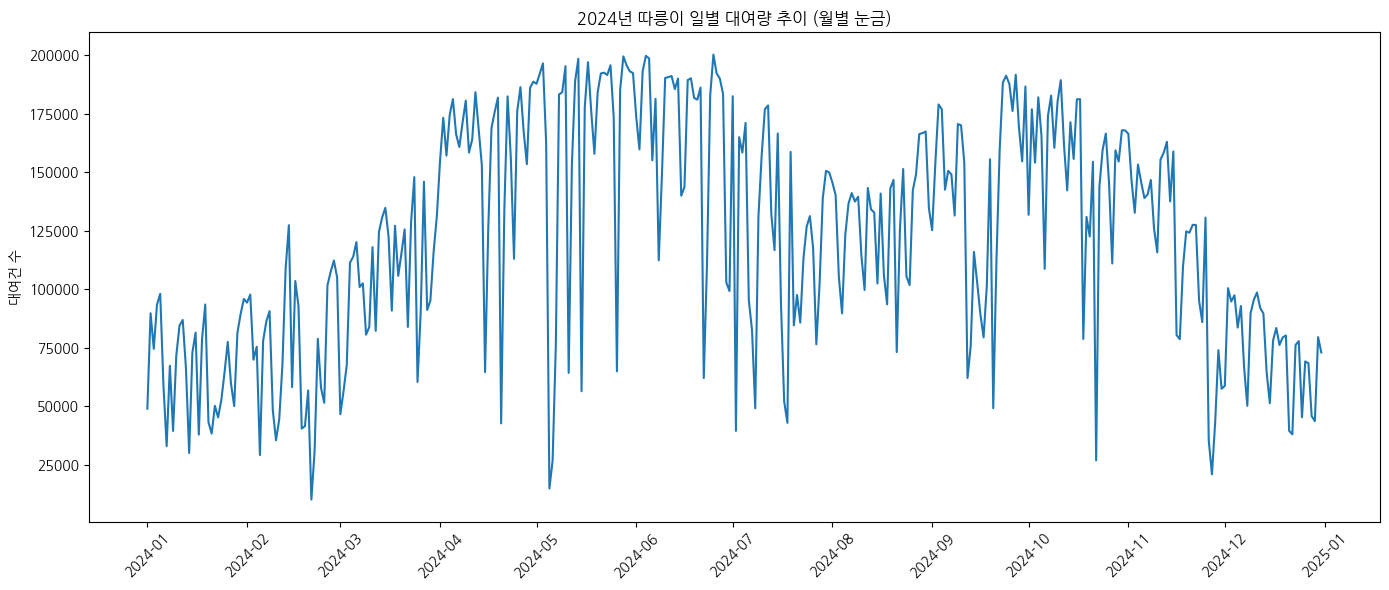

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mysql.connector
import koreanize_matplotlib

# ✅ DB 연결
conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

# ✅ 데이터 불러오기
query = "SELECT * FROM rental_daily_2024"
df = pd.read_sql(query, conn)
conn.close()

# ✅ 날짜 타입으로 변환
df["rental_date"] = pd.to_datetime(df["rental_date"])

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(df["rental_date"], df["rental_count"])

# ✅ X축: 월 단위 포맷팅
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.ylabel("대여건 수")
plt.title("2024년 따릉이 일별 대여량 추이 (월별 눈금)")
plt.tight_layout()
plt.show()
